In [2]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import scipy
import scipy.signal

# 10b: Significance

In 10a we looked at using repeated draws of a probability distibruion to find the value of somehting and to quantify uncertainty. 

Here we will use those same techniques to find the significance of a signal when it is burried in noisy data.

Previously, we've cross-correlated data with a known signal shape. We observe spikes in the cross-correlation function, which seem to indicate the presence of a signal in the noisy data. But how can we be sure that this wasn't just some particularly unlucky noise? In reality, we never can be. We can only ask: how unlikely would it have been to see something like this in noise alone.

So let's try to quantify that. We'll create a dataset with our `signal_2` added to it, but the noise will be louder than the data we used previously.

In [53]:
# Some settings for the data
sample_rate = 32 # 32 samples per second
num_data_samples = 128*sample_rate # 128 seconds worth of data
times = np.arange(num_data_samples) / sample_rate

def make_signal(gaussian_width, chirpiness):
    signal_inst_frequency = 2. + chirpiness*np.sin(2 * np.pi * 0.1 * times)
    phases = [0]
    for i in range(1,len(times)):
        phases.append(phases[-1] + 2 * np.pi * signal_inst_frequency[i] * 1./sample_rate)
    signal = np.sin(phases)
    gaussian = np.exp( - (times - 64)**2 / (2 * gaussian_width))
    signal = gaussian * np.sin(phases)
    return signal[48*sample_rate:80*sample_rate]

# Make the signals
signal_1 = make_signal(10., 0.)
signal_2 = make_signal(1., 1.)
signal_3 = make_signal(8., 4.)
signal_4 = make_signal(10., 1.)

# Make the noise, and add a signal to the noise at an unknown spot
# Set seed so we get the same dataset!
np.random.seed(21)
noise = np.random.normal(size=[num_data_samples])
rndi = np.random.randint(0,sample_rate*96)
data_21 = noise
data_21[rndi:rndi+len(signal_2)] += signal_2*0.9

## Exercise 1

* Compute the cross-correlation of data_21 with signal_2. Can you clearly see the signal in the noise?
* Create a 128-second long stretch of random noise (in the same way as we did for `data_21`, but now without a signal added). Cross-correlate with signal_2. What is the loudest value that you see?
* Repeat the process 1000 times. How many times is the maximum cross-correlation louder than it was for `data_21`? 

In [33]:
def crosscorr(data, signal):
    result = [np.sum(signal*data[idx:idx+len(signal)])
                  for idx in range(0, len(data)-len(signal))]
    return np.array(result)

In [34]:
corr_2 = crosscorr(data_21, signal_2)

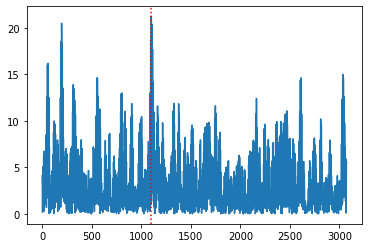

In [35]:
plt.plot(np.abs(corr_2))
plt.axvline(np.abs(corr_2).argmax(), ls=':', c='r')

Note: The peak of the signal is just barely above the noise. You can change the $0.9$ in the code that generates the data to make the signal a bit stronger. 

In [36]:
result = []
for _ in range(1000):
    my_noise = np.random.normal(size=[num_data_samples])
    result.append(np.max(np.abs(crosscorr(my_noise, signal_2))))
result = np.array(result)

In [37]:
cmax = np.max(np.abs(corr_2))

In [38]:
len(result[result>cmax])/len(result)

0.092

This time when I run it, I get 8% of the time the noise is louder than the signal.

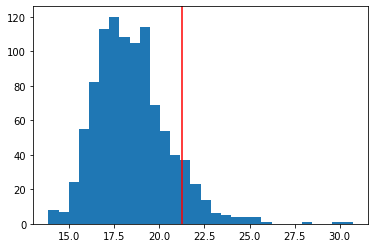

In [39]:
plt.hist(result, bins=30)
plt.axvline(cmax, c='r')

You will not get exactly the same numbers, but in my tests I saw 108 examples of noise where the cross-correlation with `signal_2` produced a larger value than for `data_21`. We know that each of those times, there actually was no signal in the data - because we generated the noise ourselves, and we know that we did not add a signal.

So in 108 out of 1000 cases, we got a peak cross-correlation larger than what we had in `data_21`, but no signal was actually present. This means is that if we had received `data_21` from a detector, we would not be totally confident that there was a real signal in the data. We can however make a statistical statement of how confident we are.

We would see a cross-correlation peak equal to or louder than the one in `data_21` in 72 out of 1000 times where there is no signal. We can express the signficance as a 10.8% chance that the signal is just a "false alarm". We can also make this a rate. Each segment of data is 128 seconds long. There are 108 false alarms in 128000 seconds of data, which is one per 1200 seconds, or about 3 per hour.

### Making things faster

It may take a minute or two to calculate 1000 cross-correlations. You may want to spend a few minutes to find out if either numpy or scipy has a correlation function that does the same thing as the cross-correlation code we've written. 

If you can find a matching function, you should test the output to make sure it does the same thing as the code we've written. Make sure you understand what the inputs and outputs of the function are.

Numpy and scipy functions often much faster than code we write. You can run an example with `%timeit` placed in front to see how fast it runs. If you switch to using this for the following cross-correlation calculations, things will go much quicker.

In [40]:
%timeit crosscorr(data_21, signal_2)

20 ms ± 1.57 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [41]:
%timeit np.correlate(data_21, signal_2)

331 µs ± 9.64 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [42]:
import scipy.signal
%timeit scipy.signal.correlate(data_21, signal_2)

522 µs ± 19 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [43]:
result1 = crosscorr(data_21, signal_2)
result2 = scipy.signal.correlate(data_21, signal_2)

In [44]:
print(len(result1), len(result2))

3072 5119


Note: The `scipy` function is fastest, but it gives a different-length result. This is because of the way it handles the edges, where the template runs off the ends of the data. See the plot:

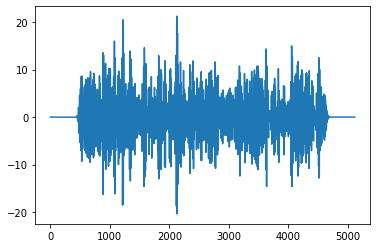

In [45]:
plt.plot(result2)

There's an optional argument `mode`. The default option of `mode='full'` gives the above behaviour. If we instead use `mode='valid'`, we get something that's the same as our convention, except with one extra point. We can compare them to check that the answers are the same.

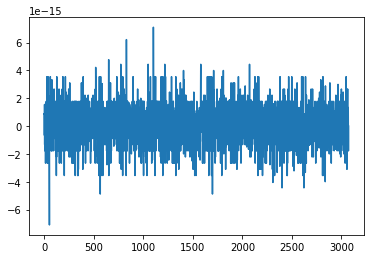

In [46]:
result3 = scipy.signal.correlate(data_21, signal_2, mode='valid')
plt.plot(result1-result3[:-1])

Compare this to the original values. These are $10^{-14}$ times smaller. That's close enough to call it the same answer. The two codes implement the same calculation but use different methods, so some numerical error is expected.

## Exercise 2

* Generate 1000 different noise datasets, using the same noise generation function as above.
* For each dataset compute the cross-correlation with `signal_1`, `signal_2`, `signal_3` and `signal_4`. Store the largest value for each signal
* (You should now have 4 length-1000 arrays with each value being the loudest value of the cross-correlation).
* Plot a cumulative histogram of these values (Look up the matplotlib examples for examples of this).
* Why are these histograms different for each signal?
* How loud does a signal have to be to go from not-at-all significant to very significant?

In [47]:
signal_1_ccs = []
signal_2_ccs = []
signal_3_ccs = []
signal_4_ccs = []

def max_correlation(data, signal):
    return np.max(np.abs(scipy.signal.correlate(data, signal, mode='valid')))

for _ in range(1000):
    noise = np.random.normal(size=[num_data_samples])

    signal_1_ccs.append(max_correlation(noise, signal_1))

    signal_2_ccs.append(max_correlation(noise, signal_2))

    signal_3_ccs.append(max_correlation(noise, signal_3))

    signal_4_ccs.append(max_correlation(noise, signal_4))

Text(0, 0.5, 'Probability that you get a value larger than x-value')

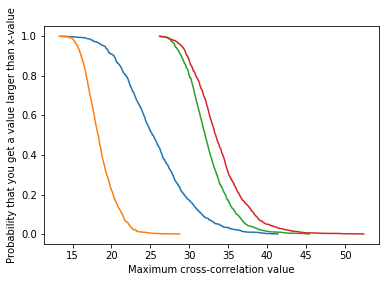

In [48]:
# SIMPLE CUMULATIVE HISTOGRAM

signal_1_ccs = np.sort(signal_1_ccs)
signal_2_ccs = np.sort(signal_2_ccs)
signal_3_ccs = np.sort(signal_3_ccs)
signal_4_ccs = np.sort(signal_4_ccs)


plt.figure()
plt.plot(signal_1_ccs, 1 - np.arange(len(signal_1_ccs))/len(signal_1_ccs))
plt.plot(signal_2_ccs, 1 - np.arange(len(signal_2_ccs))/len(signal_2_ccs))
plt.plot(signal_3_ccs, 1 - np.arange(len(signal_3_ccs))/len(signal_3_ccs))
plt.plot(signal_4_ccs, 1 - np.arange(len(signal_4_ccs))/len(signal_4_ccs))
plt.xlabel("Maximum cross-correlation value")
plt.ylabel("Probability that you get a value larger than x-value")

Why are these different? One major factor is how 'loud' each template is. If we were to multiply the signal by some factor, it doesn't change how easy it is to detect the signal. We can measure how loud the template is by the max correlation with itself. We should actually take the square root, so we get something that doubles when we multiply the template by two.

In [49]:
loud1 = np.sqrt(max_correlation(signal_1, signal_1))
loud2 = np.sqrt(max_correlation(signal_2, signal_2))
loud3 = np.sqrt(max_correlation(signal_3, signal_3))
loud4 = np.sqrt(max_correlation(signal_4, signal_4))
print(loud1, loud2, loud3, loud4)

9.469945061207762 5.325341455181225 8.755124011637596 9.46994505840157


Text(0, 0.5, 'Probability that you get a value larger than x-value')

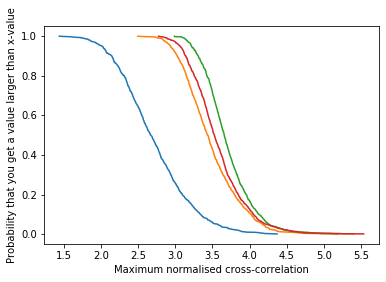

In [50]:
plt.figure()
plt.plot(signal_1_ccs/loud1, 1 - np.arange(len(signal_1_ccs))/len(signal_1_ccs))
plt.plot(signal_2_ccs/loud2, 1 - np.arange(len(signal_2_ccs))/len(signal_2_ccs))
plt.plot(signal_3_ccs/loud3, 1 - np.arange(len(signal_3_ccs))/len(signal_3_ccs))
plt.plot(signal_4_ccs/loud4, 1 - np.arange(len(signal_4_ccs))/len(signal_4_ccs))
plt.xlabel("Maximum normalised cross-correlation")
plt.ylabel("Probability that you get a value larger than x-value")

These are now much more similar. Because we are taking the maximum, there's another effect, which is how similar nearby values of the correlation are. We can see this by looking at the full auto-correlation of the templates.

In [51]:
autocorr1 = scipy.signal.correlate(signal_1, signal_1, mode='full')
autocorr4 = scipy.signal.correlate(signal_4, signal_4, mode='full')

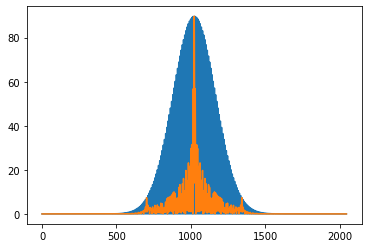

In [52]:
plt.plot(abs(autocorr1))
plt.plot(abs(autocorr4))

`signal_1` has a wider auto-correlation than `signal_4`, so it is less likely to have independent maxima.